## Part A: Preprocessing and Initial Setup

### Imports

In [1]:
import numpy as np
import pandas as pd 
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')


### **Initial Analysis of data**


Here we observe that:
- The data has no null values so no need to handle it
- The target classes are one hot encoded and they are of the datatype - bit string and hence they require some pre-processing
- All the features are of numeric values and so only scaling should be sufficient

In [2]:
data,meta=arff.loadarff("yeast.arff")
meta

Dataset: MultiLabelData
	Att1's type is numeric
	Att2's type is numeric
	Att3's type is numeric
	Att4's type is numeric
	Att5's type is numeric
	Att6's type is numeric
	Att7's type is numeric
	Att8's type is numeric
	Att9's type is numeric
	Att10's type is numeric
	Att11's type is numeric
	Att12's type is numeric
	Att13's type is numeric
	Att14's type is numeric
	Att15's type is numeric
	Att16's type is numeric
	Att17's type is numeric
	Att18's type is numeric
	Att19's type is numeric
	Att20's type is numeric
	Att21's type is numeric
	Att22's type is numeric
	Att23's type is numeric
	Att24's type is numeric
	Att25's type is numeric
	Att26's type is numeric
	Att27's type is numeric
	Att28's type is numeric
	Att29's type is numeric
	Att30's type is numeric
	Att31's type is numeric
	Att32's type is numeric
	Att33's type is numeric
	Att34's type is numeric
	Att35's type is numeric
	Att36's type is numeric
	Att37's type is numeric
	Att38's type is numeric
	Att39's type is numeric
	Att40's t

- In the below code, we extract the targets and store it in a dataframe target while also Checking for NaN values and datatype analysis

In [3]:
df=pd.DataFrame(data)

temp=df.select_dtypes(['number'])
feature_names=[]
for feature in temp:
    feature_names.append(feature)
    

temp1=df.select_dtypes(['object'])
target_names=[]
for target in temp1:
    target_names.append(target)


print(f"\n The number of features is {len(feature_names)} and the number of classes is {len(target_names)}")
print(f"\n The number of NaN values is {df.isna().any(axis=1).sum()}")

print("\n The different datatypes are:")
print(df.dtypes.value_counts())


 The number of features is 103 and the number of classes is 14

 The number of NaN values is 0

 The different datatypes are:
float64    103
object      14
Name: count, dtype: int64


- Here we convert the bit string to numeric boolean values

In [4]:
for col in df.select_dtypes([object]):
    df[col]=df[col].str.decode('utf-8')


#Feature Selection

targets=df.select_dtypes(['object'])
targets=targets.apply(pd.to_numeric)


df[["Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10","Class11","Class12","Class13","Class14"]]=targets

---
### Label selection and feature engineering

- First we segregate the datapoints so that we get the data with only asingle class label and we find that class1 and class2 are the most frequent ones among them

In [5]:
single_class_targets=targets[targets.sum(axis=1)==1]

top_two=single_class_targets.sum(axis=0)
top_two=top_two.nlargest(2) # This function is designed only for a series and returns a series with top n values. 
top_two=list(top_two.index)
print(top_two)



['Class1', 'Class2']


In [6]:
print("\n The total number of single class data points are", len(single_class_targets))
print("\n The number of datapoints with Class1 as single label is", len(single_class_targets["Class1"]))


 The total number of single class data points are 32

 The number of datapoints with Class1 as single label is 32


#### Contradiction with given instructions
- While checking the count, we see that only 32 instances have a single label and that 32 belongs to class 1 alone. This means, there is no second most frequent single class datapoints.
- So instead we will consider the class1 data alone along with top 2 most frequent combination of class labels. We see below that we get a significant amount of data in the top 2 combinations. which makes them a good choice of target variables

In [7]:
top_combination=targets[targets.sum(axis=1)>1].value_counts().idxmax()
second_combination=targets[targets.sum(axis=1)>1].value_counts().index[1]
print("\n The most frequent combination is ", top_combination)
print("\n The second most frequent combination is ", second_combination)



 The most frequent combination is  (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)

 The second most frequent combination is  (0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0)


---
Below is a helper function to create a new feature with features
- **Class1** containing data with single label belinging to Class1
- **Combination1** containing data with most frequent combination of class labels
- **Combination1** containing data with most frequent combination of class labels
- **Others** containing the remaining data

In [8]:
def feature_engineering(target):
    if target.sum()==1 and target['Class1']==1:
        return "Class1"
    # elif target.sum()==1 and target['Class2']==1:
    #     return "Class2"
    elif top_combination==tuple(target.to_numpy()):
        return "Combination_1"
    elif second_combination==tuple(target.to_numpy()):
        return "Combination_2"
    else:
        return "Others"
    
    
df["Target"]=targets.apply(feature_engineering,axis=1) # Axis parameter is confusing here


df["Target"].value_counts()

Target
Others           1915
Combination_1     237
Combination_2     233
Class1             32
Name: count, dtype: int64

---
- we then drop the one hot targets, include our new target column and segregate features and targets and scale them using sklearn standard scaler

--- 
### Why scaling is essential

Scaling is crucial for t-SNE and Isomap because both rely on distances to map high-dimensional data into lower dimensions. In our case, t-SNE computes pairwise similarities using a Gaussian kernel:  

$$
p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}
$$  

Here, the squared Euclidean distance $||x_i - x_j||^2$ directly affects the conditional probability. If one feature has a much larger scale than others, it dominates the distance, making t-SNE focus on that feature while ignoring subtle structures in the data. Scaling ensures that all features contribute proportionally, so the low-dimensional map reflects true neighborhood relationships.  

Similarly, Isomap computes geodesic distances based on a k-nearest neighbor graph, which again uses Euclidean distances in high-dimensional space. Without scaling, large-scale features distort the graph, stretching or compressing distances unevenly, and the resulting embedding misrepresents the manifold. By standardizing the data, we ensure both t-SNE and Isomap interpret distances meaningfully, producing embeddings that reveal the real structure of the data rather than artifacts of measurement units.


In [9]:
df.drop(columns=["Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10","Class11","Class12","Class13","Class14"],inplace=True)
Y=df.iloc[:,-1]
X=df.iloc[:,:-1]

X_scaled=pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)

df.head()


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103,Target
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722,Others
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161,Others
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352,Others
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0.200354,-0.075716,0.196605,0.152758,-0.028484,-0.074207,-0.089227,-0.049913,-0.043893,Others
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,0.044351,-0.057209,0.028047,0.029661,-0.050026,0.023248,-0.061539,-0.035160,0.067834,Others


---
---
## Part B: t-SNE and Veracity Inspection

- Below is a function that takes in different perplexity values and fits a tSNE model to the data to perform a dimensionality reduction
- Then the dimensionally small data is plotted for different perplexity values and visual inspections and observations are made

In [10]:

def tsne_plot(perplexities): # Even number of perplexities are to be passed in
    
    fig, axes = plt.subplots(len(perplexities)//2, 2, figsize=(24,18))
    axes = axes.flatten()
    axes = np.ravel(axes)

    palette = ["#71C3EC", "#F5A906", "#117733", "#271581"]
    
    for i, perplexity in enumerate(perplexities):
        X_tsne=TSNE(perplexity=perplexity,n_components=2,random_state=50).fit_transform(X_scaled)
        df_tsne=np.hstack((X_tsne,Y.values.reshape(-1,1)))
        df_tsne=pd.DataFrame(df_tsne,columns=["tsne1","tsne2","Target"])
        

        sns.scatterplot(x="tsne1",y="tsne2",hue="Target",data=df_tsne,palette=palette,style="Target",s=30,edgecolor="black",linewidth=0.3, ax=axes[i],legend=(i == 0)) 
        # only add legend on first plot
        axes[i].set_title(f"Perplexity = {perplexity}", fontsize=12)
        fig.suptitle("t-SNE Scatterplots for Different Perplexities", fontsize=14, y=0.98)

    plt.show()

   


        


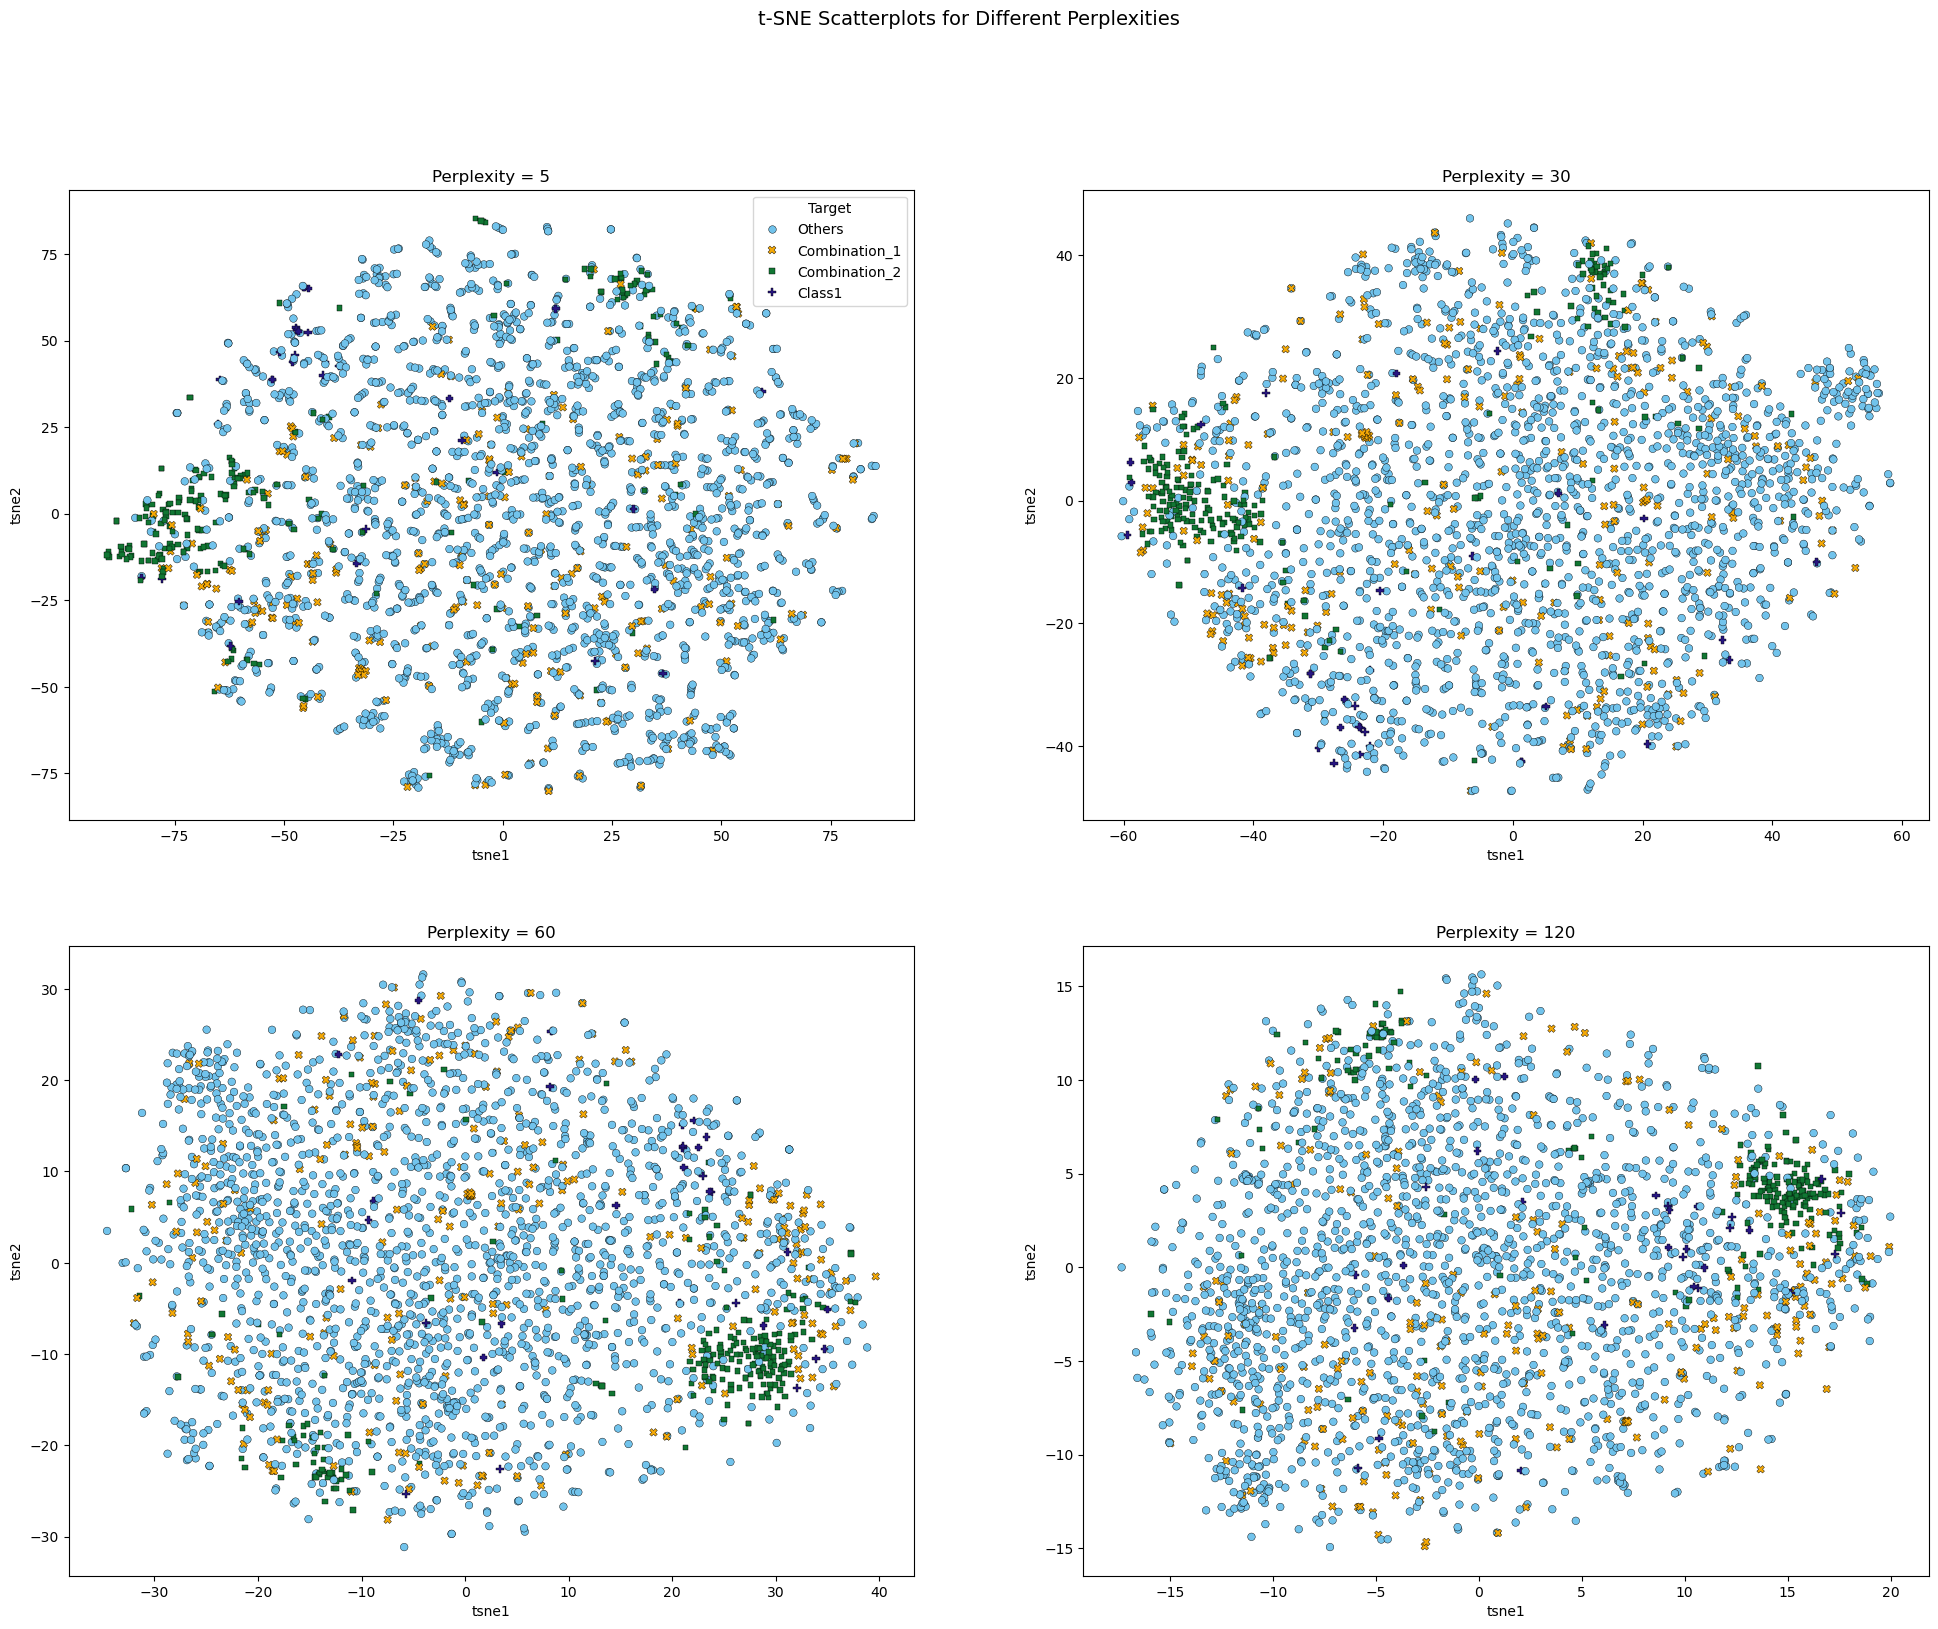

In [11]:
perplexities=[5,30,60,120]
tsne_plot(perplexities)

---
## **Observations and Veracity inspections**
---
#### **t-SNE Theoretical understanding**:

t-SNE, which stands for t-distributed Stochastic Neighbor Embedding, is a technique used to reduce high-dimensional data into two or three dimensions so we can visualize it. Unlike linear methods like PCA, t-SNE is non-linear, meaning it can capture complex structures in the data that don’t lie along a straight line.

Mathematically, t-SNE works by first converting the distances between points in the high-dimensional space into probabilities that represent how similar or “close” two points are. Then it tries to create a low-dimensional map where the points have similar probabilities of being neighbors. In the low-dimensional space, it uses a heavy-tailed distribution (Student’s t-distribution) to spread out points more effectively and avoid the crowding problem. The algorithm finds the best map by minimizing the difference between the high-dimensional and low-dimensional probability distributions using a measure called Kullback-Leibler divergence.

What makes t-SNE useful is that it preserves the local structure really well. Points that are close to each other in the original high-dimensional space usually stay close in the 2D or 3D map. This makes it great for spotting clusters or groups in the data. However, it does not preserve global distances very well, so the space between clusters in the plot is not necessarily meaningful. It also does not maintain linear relationships or overall variance like PCA does.

In short, t-SNE is very helpful for exploring patterns, clusters, and anomalies in complex datasets, but we should be careful not to interpret exact distances or absolute positions between groups in the plot.


---
#### **Observations**

  - In t-SNE, the **perplexity** parameter roughly controls the number of nearest neighbors considered when computing similarity probabilities. Low perplexity values focus on very local neighborhoods, highlighting fine-grained clusters, while high perplexity values take more points into account, which can smooth out local variations and reveal broader structures. Based on our observations, a **perplexity around 30** seems reasonable for this dataset: it preserves the well-defined “Combination 2” cluster while maintaining enough separation among the scattered or path-like points, without introducing excessive fragmentation.


- The “Others” category, shown in light blue, is very widespread across the plot for all perplexity values. This suggests that these samples do not form clear clusters and may represent **ambiguous or noisy data points**. These could be genes with weak or overlapping functional signals, making it hard for a classifier to distinguish them reliably. The lack of clear structure also implies that there may be **complex, high-dimensional relationships** that are not captured by simple features.

- The green points representing “Combination 2” form a tight cluster, but its position shifts depending on the perplexity value: for low perplexities (5 and 30), it appears on the left, while for higher perplexities (60 and 120), it shifts to the right. This can happen because t-SNE emphasizes **local neighborhood preservation over global distances**, so the absolute location of clusters is not fixed. Slight changes in perplexity affect how the algorithm balances local versus global structure, causing cluster positions to shift. The presence of a smaller secondary grouping (top-right in most plots) may reflect **biological variability or experimental subgroups** within this combination.

- - The orange points representing “Combination 1” are not completely random; they appear to follow a **path-like structure** and are intermixed with green points. This suggests that these genes may share some expression similarity with “Combination 2” but also vary along a continuous spectrum, possibly reflecting **gradual transitions in functional profiles** or **partial overlap of multi-label combinations**. Their path-like spread and mixing with the green cluster indicate that classifiers may struggle in these regions due to overlapping features. This widespread distribution could be due to several factors:
  - The genes in this combination might exhibit **heterogeneous expression patterns**, reflecting multiple underlying biological processes.
  - There could be **label noise or misannotation**, meaning some of these genes are assigned to this combination incorrectly.
  - It is also possible that this combination represents **rare or complex functional profiles** that do not form a single coherent cluster, making them hard to learn for classifiers.

- The dark blue points representing “Class1” are very few (only 32 points) and scattered across the plot. The sparsity and spread suggest that:
  - This class may correspond to **rare functional categories**, so there isn’t enough data to form a visible cluster.
  - Some points might be **outliers** or experiments with unusual expression profiles, explaining their scattered appearance.
  - Classifiers would likely struggle to learn this class because of its small size and lack of compact structure in feature space.




- Overall, these observations highlight several **veracity issues** in the dataset:
  - **Noisy/ambiguous labels**: points embedded in clusters of different colors, mainly in “Others” and “Combination 1.”
  - **Outliers**: isolated points, particularly in “Class1” and some “Others” points.
  - **Hard-to-learn samples**: regions where multiple colors are thoroughly mixed, especially where “Combination 1” overlaps with “Others.”


---
---
## Part C: Isomap and Manifold Learning

---
- Below is a function that takes in different neighbour values and fits a Isomap model to the data to perform a dimensionality reduction
- Then the dimensionally small data is plotted for different neighbour count values and visual inspections and observations are made

In [12]:

def isomap_plot(neighbours): # Even number of perplexities are to be passed in
    
    fig, axes = plt.subplots(len(neighbours)//2, 2, figsize=(24, 18))
    axes = axes.flatten()
    axes = np.ravel(axes)

    palette = ["#71C3EC", "#F5A906", "#117733", "#271581"]
    
    for i, neighbour in enumerate(neighbours):
        X_isomap=Isomap(n_neighbors=neighbour,n_components=2).fit_transform(X_scaled)

        df_isomap=pd.DataFrame(np.hstack((X_isomap,Y.values.reshape(-1,1))),columns=["isomap1","isomap2","Target"])        

        sns.scatterplot(x="isomap1",y="isomap2",hue="Target",data=df_isomap,palette=palette,style="Target",s=30,edgecolor="black",linewidth=0.3, ax=axes[i],legend=(i == 0)) 
       
        axes[i].set_title(f"Number of neighbours = {neighbour}", fontsize=12)
        fig.suptitle("Isomap Scatterplots for Different neighbour count", fontsize=14, y=0.98)

    plt.show()


c:\Users\vvads\.conda\envs\ai_env\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\vvads\.conda\envs\ai_env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\vvads\.conda\envs\ai_env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\vvads\.conda\envs\ai_env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, c

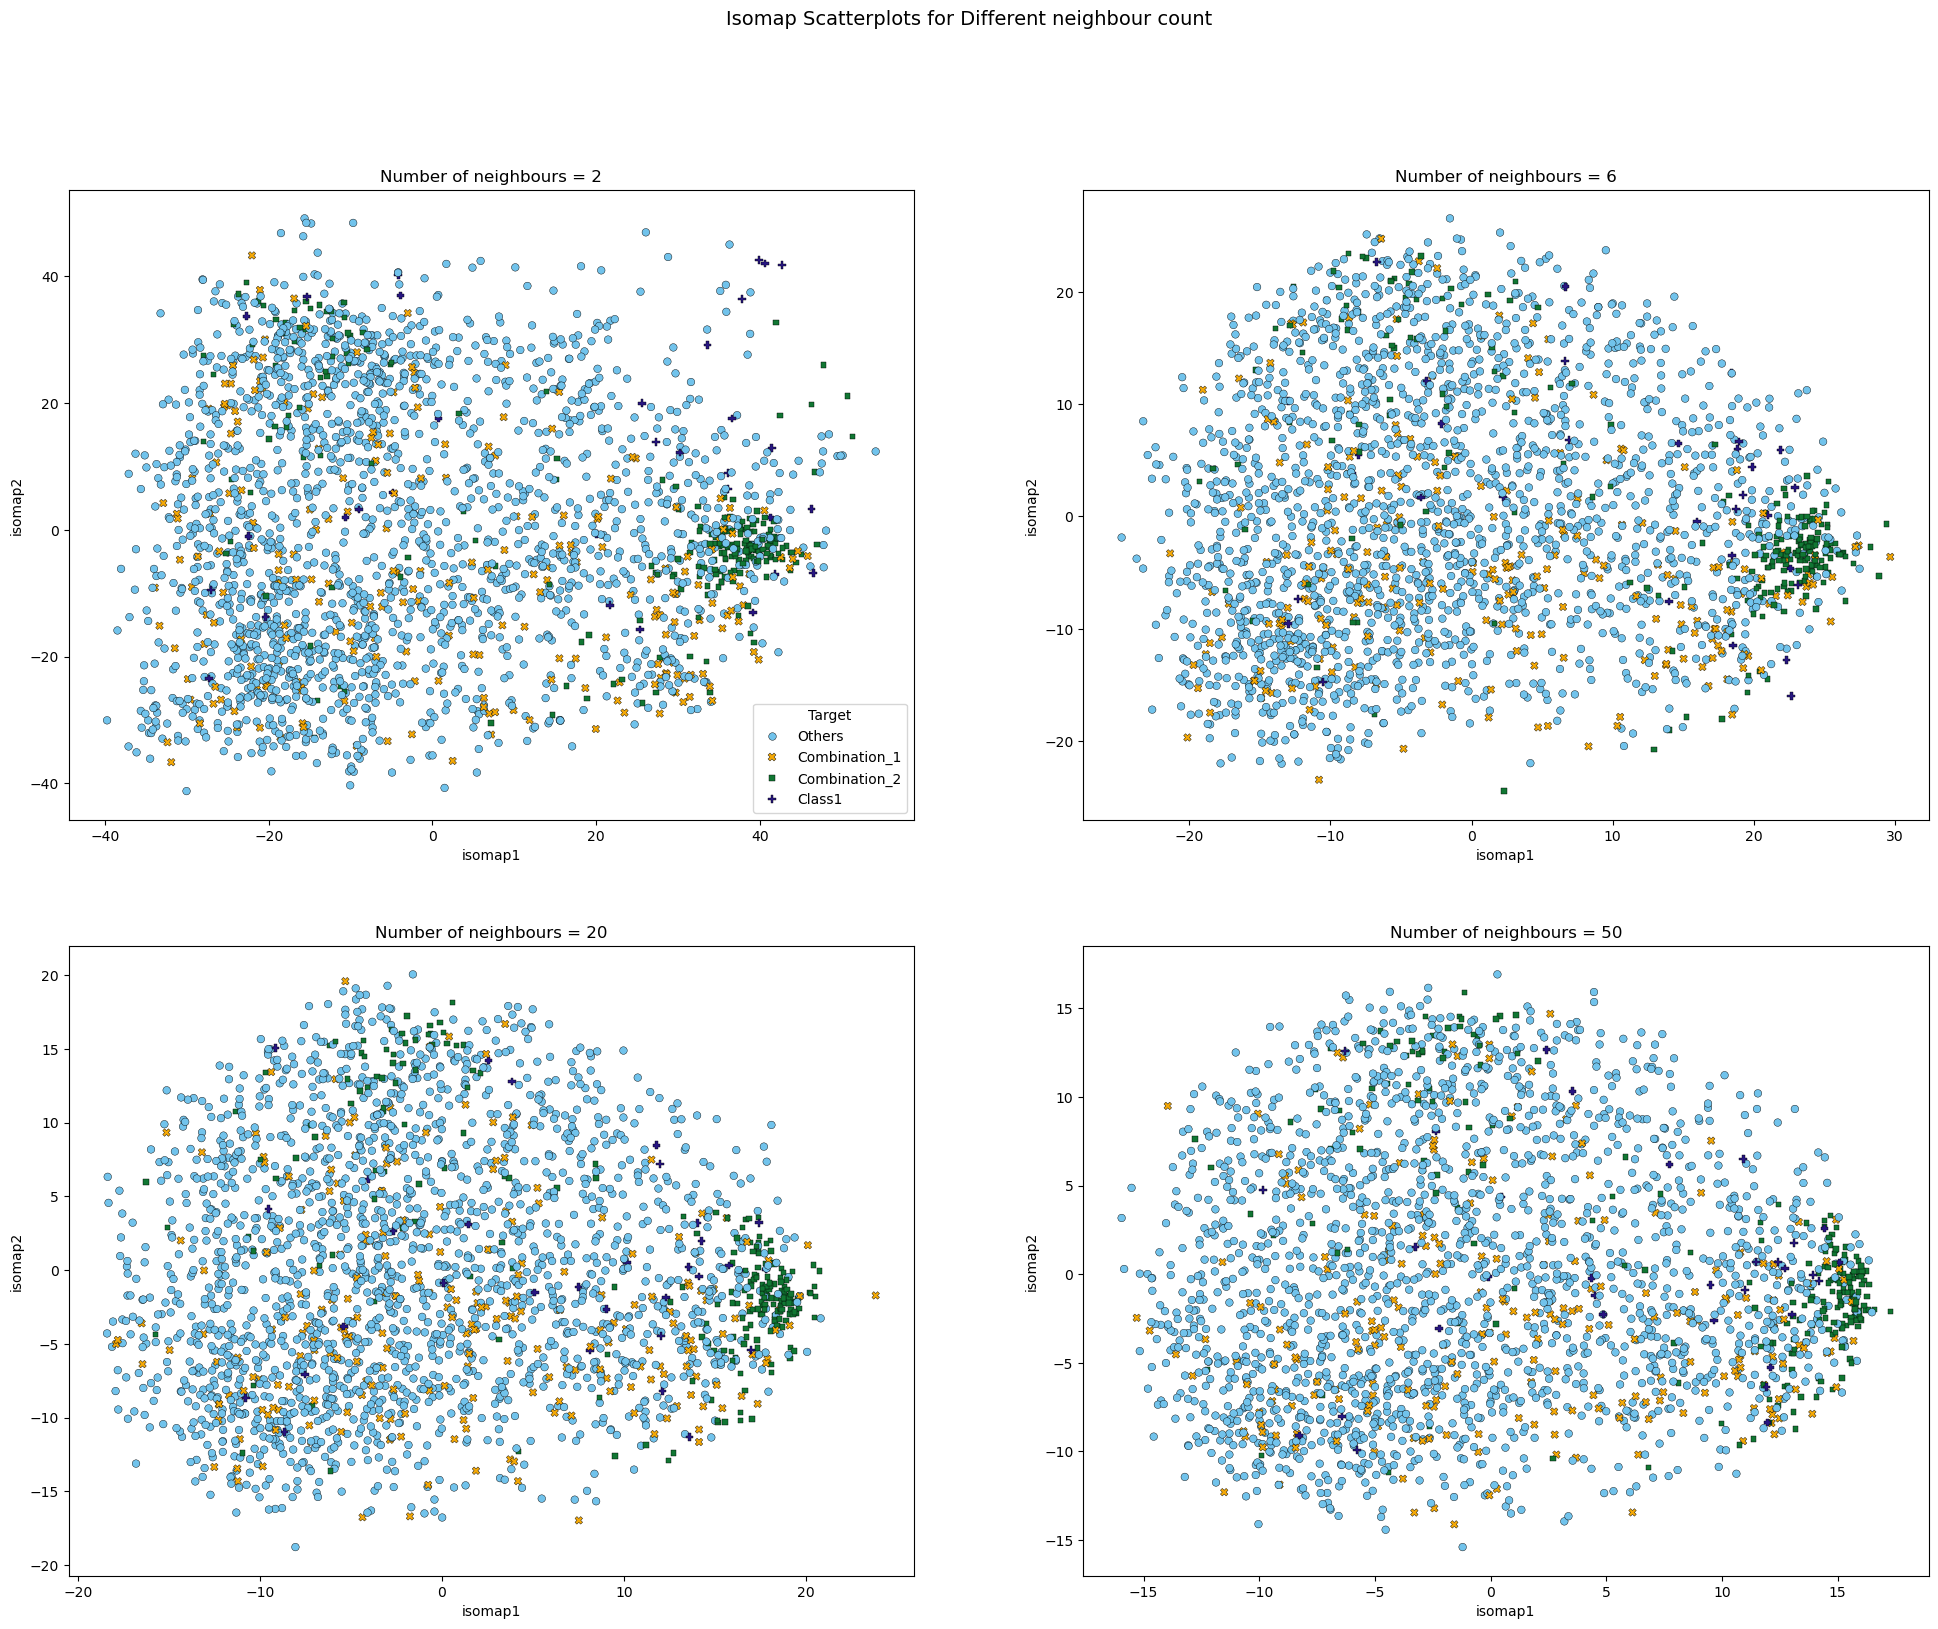

In [13]:
neighbours=[2,6,20,50]
isomap_plot(neighbours)

##  Comparison and Curvature 
---

#### **Theoretical Understandings**


Isomap is a non-linear dimensionality reduction technique that aims to preserve the **intrinsic geometry of the data**. Unlike linear methods like PCA, which only capture global variance along straight directions, Isomap attempts to maintain the **geodesic distances** between points on the underlying manifold. This is done by first constructing a neighborhood graph of the data, computing shortest paths (approximating geodesic distances) between all pairs of points, and then applying classical multidimensional scaling (MDS) to embed these distances in a lower-dimensional space.

The key difference between Isomap and t-SNE lies in what they prioritize. t-SNE focuses on **preserving local structure**, meaning it keeps points that are close in high-dimensional space close in the low-dimensional map, but it does not reliably preserve global distances or the overall layout of clusters. In contrast, Isomap tries to preserve **both local and global relationships**, so the relative positions of clusters and their overall manifold structure are more faithfully represented.

In essence, t-SNE is excellent for highlighting **local clusters and patterns** but can distort global geometry, while Isomap provides a more **faithful view of the manifold structure**, helping us understand how clusters relate to each other in a global sense. Both are non-linear methods, but their contrasting goals—local versus global structure preservation—make them complementary tools for visual exploration of high-dimensional data.

---

### **Observations**

Comparing the Isomap visualization to the t-SNE plot, we can see some clear differences in how global and local structures are represented. In t-SNE, the primary focus is on preserving local neighborhoods, so clusters such as “Combination 2” are tightly packed, but the relative positions of clusters and the spread of the “Others” category do not reflect meaningful global distances. Isomap, on the other hand, preserves the **geodesic distances along the data manifold**, which allows us to see a more faithful representation of the global structure. For example, in the Isomap plot, “Combination 2” forms a primary cluster on the right with a smaller secondary cluster at the top, while the rest of the data is randomly scattered. This suggests that Isomap provides a better view of the overall arrangement of the points, showing both cluster separations and their relative positions in the high-dimensional space.

The concept of a **data manifold** is central to understanding these plots. A manifold is a low-dimensional structure embedded in the high-dimensional space that the data approximately lies on. In the Isomap visualization, the presence of a main cluster with a smaller secondary cluster, combined with widely scattered points elsewhere, suggests a **moderately curved or complex manifold**, rather than a simple flat structure. The complexity of this manifold indicates that classifiers may have difficulty, because points belonging to different functional categories can be close in some parts of the manifold or spread across multiple regions, making simple linear decision boundaries insufficient.

The role of the **number of neighbors** in Isomap is also important. When the number of neighbors is very small (e.g., 2), the neighborhood graph becomes sparse, which leads to embeddings with many small groups of points and large white spaces. This reflects that only very local connections are being preserved, causing the manifold to appear fragmented. Increasing the number of neighbors smooths the graph and connects more points, but in our data, further increasing the neighbors beyond a moderate value does not dramatically change the plot. This suggests that the intrinsic structure of the data is relatively robust, and the global manifold is being captured without large distortions, even with a moderate neighborhood size.

  


---
---